#**Project MiLe End: ECS708P mini project submission**

**Student Name:** ```Nirbhay Vishwanath Worlikar``` 

**Student ID:** ```210008012```

**Email Id:** ```n.worlikar@se20.qmul.ac.uk```



---



#**Summary** 

We have developed a model to predict the intonation of a short audio segment using the MLEnd dataset. The MLEnd dataset contains the set of audio files for spoken numeral. We have compared different classification models which can be the best fit for the prediction of the intonation.

# Environment set up

In this section we will set up a Colab environment for the MLEnd mini-project. Before starting, follow these simple instructions: 

1.   Go to https://drive.google.com/
2.   Create a folder named 'Data' in 'MyDrive'. On the left, click 'New' > 'Folder', enter the name 'Data', and click 'create'
3.   Open the 'Data' folder and create a folder named 'MLEnd'.
4.   Move the file 'trainingMLEnd.csv' to the newly created folder 'MyDrive/Data/MLEnd'.

Run the Following code cells to mount the Drive after performing above steps

In [1]:
from google.colab import drive

import numpy as np
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys, re, pickle, glob
import urllib.request
import zipfile


#from IPython.display import Audio
import IPython.display as ipd
from tqdm import tqdm
import librosa
drive.mount('/content/drive')

Mounted at /content/drive


Run the following cell to check that the MLEnd folder contains the file 'trainingMLEnd,csv':

In [2]:
path = '/content/drive/MyDrive/Data/MLEnd'
os.listdir(path)

['trainingMLEnd.csv', 'training.zip', 'training']

#Data Download for Dataset

In this section we will download the data that you need to build your solutions. Note that even though we call it "training" dataset you can do whatever you want with it, for instance validation tasks. Note that we keep a separate dataset for testing purposes, which we won't share with anyone.

First, we will define a function that will allow us to download a file into a chosen location.

In [ ]:
def download_url(url, save_path):
    with urllib.request.urlopen(url) as dl_file:
        with open(save_path, 'wb') as out_file:
            out_file.write(dl_file.read())

            

The next step is to download the file 'training.zip' into the folder 'MyDrive/Data/MLEnd'. Note that this might take a while.

In [ ]:
url  = "https://collect.qmul.ac.uk/down?t=4LO0R0TSLPGGHJPC/45O137K56GGVDFUT9AH4ST0" 
save_path = '/content/drive/MyDrive/Data/MLEnd/training.zip'
download_url(url, save_path)

Finally, let's unzip the training file.

In [ ]:
directory_to_extract_to = '/content/drive/MyDrive/Data/MLEnd/training/'
with zipfile.ZipFile(save_path, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

Once this step is completed, you should have all the audio files in the location 'MyDrive/Data/MLEnd/training/training'.

#Dataset Preparation

Let's check how many audio files we have in our training dataset:

In [3]:
files = glob.glob('/content/drive/MyDrive/Data/MLEnd/training/*/*.wav')
len(files)

20000

The output figure of the above code cell corresponds to the number of items or samples in our dataset. Let's listen to some random audio files:

In [5]:
# five random files
for _ in range(3):
  n = np.random.randint(20000)
  display(ipd.Audio(files[n]))

Let's now load the contents of 'trainingMLEnd.csv' into a pandas DataFrame and explore them:

In [6]:
labels = pd.read_csv('/content/drive/MyDrive/Data/MLEnd/trainingMLEnd.csv')
labels

,File ID,digit_label,participant,intonation
0,0000000.wav,4,S73,question
1,0000001.wav,2,S88,excited
2,0000002.wav,70,S5,neutral
3,0000003.wav,2,S85,bored
4,0000004.wav,4,S30,excited
...,...,...,...,...
19995,0019995.wav,90,S163,excited
19996,0019996.wav,10,S99,question
19997,0019997.wav,90,S46,question
19998,0019998.wav,19,S13,neutral


This file consists of 20k rows and 4 columns. Each row corresponds to one of the items in our dataset, and each item is described by four attributes:

1. File ID (audio file)
2. Numeral (digit_label)
3. Participand ID 
4. Intonation





**Feature extraction : Pitch**

Audio files are complex data types. Specifically they are discrete signals or time series, consisting of values on a 1D grid. These values are known as samples themselves, which might be a bit confusing, as we have used this term to refer to the items in our dataset. The sampling frequency is the rate at which samples in an audio file are produced. For instance a sampling frequency of 5HZ indicates that 5 produce 5 samples per second, or 1 sample every 0.2 s.

Let's plot one of our audio signals:

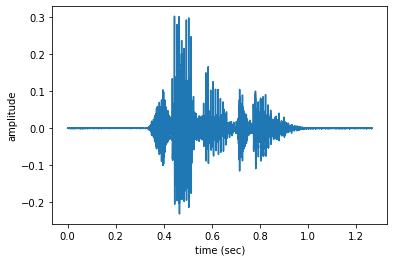

In [7]:
n=9
fs = None # Sampling frequency. If None, fs would be 22050
x, fs = librosa.load(files[n],sr=fs)
t = np.arange(len(x))/fs
plt.plot(t,x)
plt.xlabel('time (sec)')
plt.ylabel('amplitude')
plt.show()
display(ipd.Audio(files[n]))

In [8]:
files[n]

'/content/drive/MyDrive/Data/MLEnd/training/Training/0000497.wav'

Let's start by looking at the number of samples in one of our audio files:

Here for example n=9

In [9]:
n=9
x, fs = librosa.load(files[n],sr=fs)
print('This audio signal has', len(x), 'samples')

This audio signal has 27904 samples


One approach is to extract a few features from our signals and use these features instead as predictors. In the following cell, we define a function that extracts four features from an audio signal, namely:

1. Power.
2. Pitch mean.
3. Pitch standard deviation.
4. Fraction of voiced region.

In [10]:
def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag

Let's now consider the problem of identifying the intonation for the spoken numeral. Then next cell defines a function that takes a number of files and creates a NumPy array containing the 4 audio features used as predictors (`X`) and their labels (`y`). 

In [11]:
def getXy(files,labels_file,scale_audio=False, onlySingleDigit=False):
  X,y =[],[]
  for file in tqdm(files):
    fileID = file.split('/')[-1]
    yi = list(labels_file[labels_file['File ID']==fileID]['intonation'])[0]
    fs = None 
    x, fs = librosa.load(file,sr=fs)
    if scale_audio: x = x/np.max(np.abs(x))
    f0, voiced_flag = getPitch(x,fs,winLen=0.02)
      
    power = np.sum(x**2)/len(x)
    pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
    pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
    voiced_fr = np.mean(voiced_flag)

    xi = [power,pitch_mean,pitch_std,voiced_fr]
    X.append(xi)
    y.append(yi)
  return np.array(X),np.array(y)

Let's apply getXy to all the audio files. we are using first 500 files from dataset.

In [12]:
X,y = getXy(files[:500],labels_file=labels,scale_audio=True, onlySingleDigit=True)

# If you want to use all 20000 files, run next line instead
#X,y = getXy(files,labels_file=labels,scale_audio=True, onlySingleDigit=True)


100%|██████████| 500/500 [03:49<00:00,  2.18it/s]


The next cell shows the shape of `X` and `y` and prints the labels vector `y`:

In [13]:
print('The shape of X is', X.shape) 
print('The shape of y is', y.shape)
print('The labels vector is', y)


The shape of X is (500, 4)
The shape of y is (500,)
The labels vector is ['bored' 'question' 'excited' 'excited' 'question' 'excited' 'neutral'
 'bored' 'neutral' 'neutral' 'neutral' 'bored' 'bored' 'question'
 'neutral' 'bored' 'neutral' 'neutral' 'question' 'excited' 'neutral'
 'excited' 'bored' 'excited' 'bored' 'neutral' 'bored' 'bored' 'bored'
 'excited' 'question' 'excited' 'neutral' 'neutral' 'neutral' 'neutral'
 'neutral' 'question' 'question' 'bored' 'question' 'bored' 'bored'
 'question' 'neutral' 'bored' 'excited' 'bored' 'bored' 'question'
 'question' 'bored' 'bored' 'question' 'excited' 'neutral' 'bored'
 'neutral' 'neutral' 'neutral' 'excited' 'bored' 'excited' 'excited'
 'question' 'excited' 'question' 'bored' 'question' 'neutral' 'bored'
 'bored' 'neutral' 'bored' 'question' 'neutral' 'excited' 'question'
 'excited' 'question' 'neutral' 'excited' 'neutral' 'excited' 'neutral'
 'neutral' 'excited' 'excited' 'bored' 'bored' 'question' 'question'
 'question' 'bored' 'neutr

Finally, to be on the cautious side, let's eliminate any potential item with a NaN (not a number).

In [14]:
# If nan sample, remove them
if np.sum(np.isnan(X)):
  idx = np.isnan(X).sum(1)>0
  X = X[~idx]
  y = y[~idx]
print(np.sum(np.isnan(X)))

0


# **Data Preprocessing**

Splitting data into train and test sets, here we are keeping the size of test data is 30% of the total dataset

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.3)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

range_val = len(X_val)
print(range_val)

150



Feature Scaling by using standardscalar to preprocess data for model requirements

In [17]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_val = sc_X.transform(X_val)


#Data Visualisation

The dataset can be visualised using the following clusering techniques to understand its nature.

**Clustering Techniques**

1. K-Means Clustering 
2. Hierarchical Clustering



K-Means Clustering

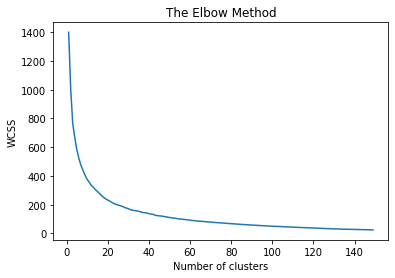

In [18]:
from sklearn.cluster import KMeans
# Within Cluster Sum of Squares (WCSS)
wcss = []
#for i in range(1, 10):
for i in range(1, range_val):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
    kmeans.fit(X_train)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, range_val), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.ion()
plt.show()
plt.pause(2)
plt.close()



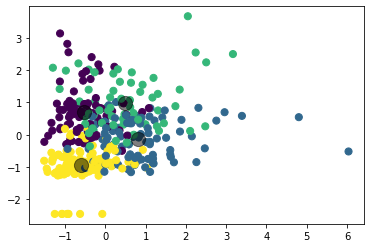

In [19]:
# Training the K-Means model on the dataset

kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 0)
y_kmeans = kmeans.fit_predict(X_train)

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.ion()
plt.show()
plt.pause(2)
plt.close()

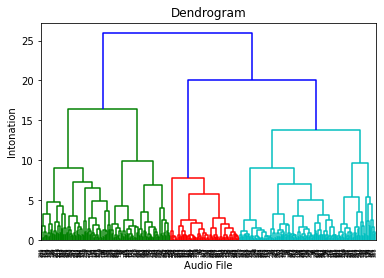

In [20]:
# Hierarchy clustering
import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(X_train, method  = "ward"))
plt.title('Dendrogram')
plt.xlabel('Audio File')
plt.ylabel('Intonation')
plt.ion()
plt.show()
plt.pause(4)
plt.close()

# **Modeling:**

Importing all required models from sklearn library

In [21]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier


1. **SVM - Support Vector Machine**

Let's build a support vector machine (SVM) model for the predictive task of identifying digits in an audio signal, using the dataset that we have just created.

We will use the SVM method provided by scikit-learn and will split the dataset defined by X and y into a training set and a validation set.

In [23]:
svm_model  = SVC(C=1, random_state=0, probability=True)
svm_model.fit(X_train,y_train)

yt_p_svm = svm_model.predict(X_train)
yv_p_svm = svm_model.predict(X_val)

print('Training Accuracy', np.mean(yt_p_svm==y_train))
print('Validation  Accuracy', np.mean(yv_p_svm==y_val))

Training Accuracy 0.56
Validation  Accuracy 0.44


Compare the training and validation accuracies. What do you observe? What do you think the accuracy of a random classifier would be?

Let's normalise the predictors, to see if the performance improves.

In [24]:
mean = X_train.mean(0)
sd =  X_train.std(0)

X_train1 = (X_train-mean)/sd
X_val1  = (X_val-mean)/sd

svm_model  = SVC(C=1,gamma=2, random_state=0, probability=True)
svm_model.fit(X_train1,y_train)

yt_p_svm = svm_model.predict(X_train1)
yv_p_svm = svm_model.predict(X_val1)

print('Training Accuracy', np.mean(yt_p_svm==y_train))
print('Validation  Accuracy', np.mean(yv_p_svm==y_val))

Training Accuracy 0.7742857142857142
Validation  Accuracy 0.47333333333333333


2. **Random Forest Algorithm**

Random forest Algorithm is a type of a classifier model which can be used to predict the intonation and we can compare its performance with respect to SVM.

Here in the below code we have assumed the n_estimator value to be 500. we then calculate Training and Validation accuracy.


In [25]:
rfa_model = RandomForestClassifier(n_estimators = 500, criterion = 'entropy', random_state = 0)
rfa_model.fit(X_train,y_train)

yt_p_rfa = rfa_model.predict(X_train)
yv_p_rfa = rfa_model.predict(X_val)

print('Training Accuracy', np.mean(yt_p_rfa==y_train))
print('Validation  Accuracy', np.mean(yv_p_rfa==y_val))


Training Accuracy 1.0
Validation  Accuracy 0.49333333333333335


3. **KNN (K-Nearest Neighbours Classification**

KNN is yet another classifier which using strategy of finding the nearest node and perform classification.


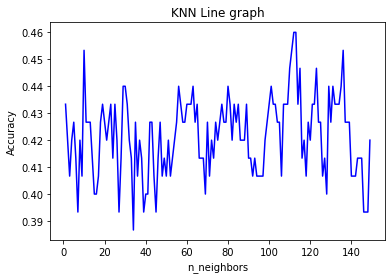

Training Accuracy 0.5685714285714286
Validation  Accuracy 0.42


In [26]:
scores = []
index = range(1, range_val)
for i in range(1, range_val):
    classifier = KNeighborsClassifier(n_neighbors=i)
    classifier.fit(X_train, y_train)
    scores.append(classifier.score(X_val, y_val))
plt.title("KNN Line graph")
plt.xlabel("n_neighbors")
plt.ylabel("Accuracy")
plt.plot(index, scores, color="blue")
plt.ion()
plt.show()
plt.pause(2)
plt.close()


knn_model = KNeighborsClassifier(n_neighbors = 8)
knn_model.fit(X_train, y_train)

yt_p_knn = knn_model.predict(X_train)
yv_p_knn = knn_model.predict(X_val)

print('Training Accuracy', np.mean(yt_p_knn==y_train))
print('Validation  Accuracy', np.mean(yv_p_knn==y_val))


#Performance Evaluation of Models

Classification Report, Confusion matrix and Accuracy Score with ROC values of all the models used to predict the intonation.

SVM               precision    recall  f1-score   support

       bored       0.41      0.33      0.37        39
     excited       0.48      0.60      0.53        35
     neutral       0.42      0.48      0.44        42
    question       0.65      0.50      0.57        34

    accuracy                           0.47       150
   macro avg       0.49      0.48      0.48       150
weighted avg       0.48      0.47      0.47       150



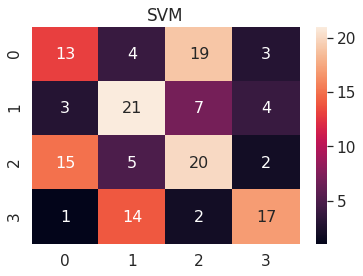



KNN               precision    recall  f1-score   support

       bored       0.39      0.44      0.41        39
     excited       0.44      0.43      0.43        35
     neutral       0.34      0.38      0.36        42
    question       0.60      0.44      0.51        34

    accuracy                           0.42       150
   macro avg       0.44      0.42      0.43       150
weighted avg       0.43      0.42      0.42       150



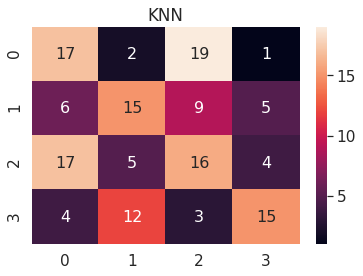



RFA               precision    recall  f1-score   support

       bored       0.49      0.49      0.49        39
     excited       0.49      0.57      0.53        35
     neutral       0.48      0.48      0.48        42
    question       0.54      0.44      0.48        34

    accuracy                           0.49       150
   macro avg       0.50      0.49      0.49       150
weighted avg       0.50      0.49      0.49       150



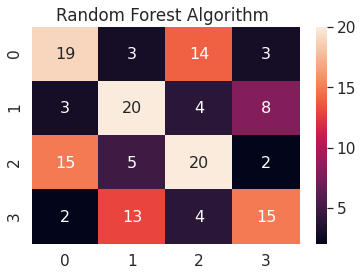

In [28]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("SVM", classification_report(y_val,yv_p_svm))
cm_svm = confusion_matrix(y_val, yv_p_svm)
sns.set(font_scale=1.4) # for label size
sns.heatmap(cm_svm, annot=True, annot_kws={"size": 16}) # font size
plt.title("SVM")
plt.show()
print("\n")
print("KNN", classification_report(y_val,yv_p_knn))
cm_knn = confusion_matrix(y_val, yv_p_knn)
sns.set(font_scale=1.4) # for label size
sns.heatmap(cm_knn, annot=True, annot_kws={"size": 16}) # font size
plt.title("KNN")
plt.show()
print("\n")
print("RFA", classification_report(y_val,yv_p_rfa))
cm_rfa = confusion_matrix(y_val, yv_p_rfa)
sns.set(font_scale=1.4) # for label size
sns.heatmap(cm_rfa, annot=True, annot_kws={"size": 16}) # font size
plt.title("Random Forest Algorithm ")
plt.show()


Accuracy Scores are calculated using **accuracy_score** function from sklearn library

In [29]:
accuracy_score(y_train, yt_p_svm)
print("Accuracy for Training SVM: {:.2f} %".format(accuracy_score(y_train,yt_p_svm)*100))
accuracy_score(y_val, yv_p_svm)
print("Accuracy for Validation SVM: {:.2f} %".format(accuracy_score(y_val,yv_p_svm)*100))

accuracy_score(y_train, yt_p_knn)
print("Accuracy for Training KNN: {:.2f} %".format(accuracy_score(y_train,yt_p_knn)*100))
accuracy_score(y_val, yv_p_knn)
print("Accuracy for Validation KNN: {:.2f} %".format(accuracy_score(y_val,yv_p_knn)*100))

accuracy_score(y_train, yt_p_rfa)
print("Accuracy for Training RFA: {:.2f} %".format(accuracy_score(y_train,yt_p_rfa)*100))
accuracy_score(y_val, yv_p_rfa)
print("Accuracy for Validation RFA: {:.2f} %".format(accuracy_score(y_val,yv_p_rfa)*100))


Accuracy for Training SVM: 77.43 %
Accuracy for Validation SVM: 47.33 %
Accuracy for Training KNN: 56.86 %
Accuracy for Validation KNN: 42.00 %
Accuracy for Training RFA: 100.00 %
Accuracy for Validation RFA: 49.33 %


ROC Curve Score

In [30]:
from sklearn.metrics import roc_auc_score

# Finding probabilities for roc_auc_score
svm_probabilities = svm_model.predict_proba(X_train)

# Finding probabilities for roc_auc_score
rf_probabilities = rfa_model.predict_proba(X_train)

# Finding probabilities for roc_auc_score
knn_probabilities = knn_model.predict_proba(X_train)

svm_roc_auc_score = roc_auc_score(y_train, svm_probabilities, multi_class="ovr")
print("ROC accuracy Score for SVM : {:.5f} ".format(svm_roc_auc_score))

knn_roc_auc_score = roc_auc_score(y_train, knn_probabilities, multi_class="ovr")
print("ROC accuracy Score for KNN : {:.5f} ".format(knn_roc_auc_score))

rfa_roc_auc_score = roc_auc_score(y_train, rf_probabilities, multi_class="ovr")
print("ROC accuracy Score for Random Forest Algorithm : {:.5f} ".format(rfa_roc_auc_score))


ROC accuracy Score for SVM : 0.92700 
ROC accuracy Score for KNN : 0.83515 
ROC accuracy Score for Random Forest Algorithm : 1.00000 


#**Conclusion: Basic Solution**

In basic solution we have compare different classification models for predicting the intonation of the audio file played. As per the comparison of the models and their performance evaluations, we can state that Random Forest Algorithm is the most suitable model for the prediction as it has achieved the highest validation accuracy of 49.33%. Followed by the SVM model and the KNN model. The accuracy of the SVM model could be further improved by changing the hyper parameters. 





---



#**Advance Model**

**Summary:** In Advance model, we are again using the same MLEnd dataset and also working on the same Features extracted from the dataset like pitch, power, etc. 
for advance model we can try to recognise the numerical spoken in the audio file using a simple neural network.





Lets perform the same process and function for feature extraction. using the librosa library .

In [31]:
def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag

Here we work on label named "Digit_label" so that we can train and validate the model prediction with the values under Digit_label.

In [32]:
def getXy1(files,labels_file,scale_audio=False, onlySingleDigit=False):
  X,y =[],[]
  for file in tqdm(files):
    fileID = file.split('/')[-1]
    yi = list(labels_file[labels_file['File ID']==fileID]['digit_label'])[0]
    if onlySingleDigit and yi>9:
      continue
    else:
      fs = None # if None, fs would be 22050
      x, fs = librosa.load(file,sr=fs)
      if scale_audio: x = x/np.max(np.abs(x))
      f0, voiced_flag = getPitch(x,fs,winLen=0.02)
      
      power = np.sum(x**2)/len(x)
      pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
      pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
      voiced_fr = np.mean(voiced_flag)

      xi = [power,pitch_mean,pitch_std,voiced_fr]
      X.append(xi)
      y.append(yi)
  return np.array(X),np.array(y)

Similar to basic solution, we now get the values of X and y for Predictions, we are considering first 500 files

In [33]:
X,y = getXy1(files[:500],labels_file=labels,scale_audio=True, onlySingleDigit=True)


100%|██████████| 500/500 [00:45<00:00, 11.07it/s]


Now lets check what the values in label vector and the shape of X and y.

In [34]:
print('The shape of X is', X.shape) 
print('The shape of y is', y.shape)
print('The labels vector is', y)


The shape of X is (157, 4)
The shape of y is (157,)
The labels vector is [1 9 6 3 5 5 5 2 9 0 5 2 4 7 7 4 4 6 2 0 4 3 4 9 5 6 6 0 9 3 9 4 1 6 5 0 6
 7 5 9 6 1 9 3 5 5 0 1 9 3 7 3 1 8 4 0 8 9 1 6 1 9 7 4 5 0 1 3 6 9 3 5 5 0
 4 2 5 2 8 3 2 1 0 4 5 7 7 9 0 2 7 2 4 6 0 7 9 8 4 7 7 6 7 1 0 3 7 3 9 5 3
 0 3 0 0 1 0 6 4 7 6 4 5 7 8 9 3 4 6 8 1 4 4 0 3 1 1 1 1 3 1 3 7 1 5 8 5 5
 2 3 7 9 7 6 2 5 3]


here we remove any IsNAN sample

In [35]:
# If nan sample, remove them
if np.sum(np.isnan(X)):
  idx = np.isnan(X).sum(1)>0
  X = X[~idx]
  y = y[~idx]
print(np.sum(np.isnan(X)))

0


Similar to Basic solution, here we do Splitting of data into train and test sets by test size 30%

In [36]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.3)
X_train.shape, X_val.shape, y_train.shape, y_val.shape


((109, 4), (48, 4), (109,), (48,))

Now we are using Keras library for building the simple Neural Network for predicting and recognition of the spoken numeral in the audio file

In [37]:
import warnings
warnings.filterwarnings('ignore')

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.callbacks import EarlyStopping
# Build a simple dense model with early stopping and softmax for categorical classification, remember we have 30 classes
model = Sequential()
#model.add(Dense(193, input_shape=(193,), activation = 'relu'))
model.add(Dense(256, activation='relu', input_shape= (X_train.shape[1],)))

model.add(Dense(128, activation = 'relu'))

model.add(Dense(64, activation = 'relu'))

model.add(Dense(32, activation = 'softmax'))

model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
#early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

Here we try to fit the model with batch size 256 and epoch size 100

In [38]:
history = model.fit(X_train, y_train, batch_size=256, epochs=100, validation_data=(X_val, y_val))

Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 19.0613 - accuracy: 0.0092 - val_loss: 14.3654 - val_accuracy: 0.0000e+00
Epoch 2/100
1/1 [==============================] - 0s 56ms/step - loss: 13.3840 - accuracy: 0.0000e+00 - val_loss: 9.4338 - val_accuracy: 0.0208
Epoch 3/100
1/1 [==============================] - 0s 48ms/step - loss: 8.5854 - accuracy: 0.0734 - val_loss: 6.6639 - val_accuracy: 0.1667
Epoch 4/100
1/1 [==============================] - 0s 51ms/step - loss: 5.8170 - accuracy: 0.1193 - val_loss: 5.8048 - val_accuracy: 0.0000e+00
Epoch 5/100
1/1 [==============================] - 0s 52ms/step - loss: 4.8905 - accuracy: 0.0826 - val_loss: 5.3685 - val_accuracy: 0.0417
Epoch 6/100
1/1 [==============================] - 0s 53ms/step - loss: 4.6780 - accuracy: 0.1560 - val_loss: 4.5847 - val_accuracy: 0.0208
Epoch 7/100
1/1 [==============================] - 0s 52ms/step - loss: 4.1573 - accuracy: 0.1009 - val_loss: 4.2016 - val_accuracy: 0.0417
Epoch 8

After the model is build we test the model by predicting the training and validation and also calculate their accuracies.

In [39]:

yt_p_nn = model.predict_classes(X_train)
yv_p_nn = model.predict_classes(X_val)

print('Training Accuracy', np.mean(yt_p_nn==y_train))
print('Validation  Accuracy', np.mean(yv_p_nn==y_val))

accuracy_score(y_train, yt_p_nn)
print("Accuracy for Training: {:.2f} %".format(accuracy_score(y_train,yt_p_nn)*100))
accuracy_score(y_val, yv_p_nn)
print("Accuracy for Validation: {:.2f} %".format(accuracy_score(y_val,yv_p_nn)*100))

Training Accuracy 0.27522935779816515
Validation  Accuracy 0.0625
Accuracy for Training: 27.52 %
Accuracy for Validation: 6.25 %


#**Conclusion : Advance Solution**
 
In the Advance Solution we have built a simple neural network model to predict and recognize the spoken numeral from the audio file. It can further be improved by changing the batch size or adding some deeper neurons to the neural network  model which will increase the accuracy.



---

